## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [ ]:
!pip install gym-minigrid &>/dev/null
!pip install --upgrade gym[atari]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.0 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade git+https://github.com/openai/gym
!pip install autorom

  Cloning https://github.com/openai/gym to /tmp/pip-req-build-neocofj8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/gym /tmp/pip-req-build-neocofj8
  Resolved https://github.com/openai/gym to commit dcd185843a62953e27c2d54dc8c2d647d604b635
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!git clone https://github.com/kehemo/uaas

Cloning into 'uaas'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 65 (delta 29), reused 28 (delta 8), pack-reused 0
Receiving objects: 100% (65/65), 1.12 MiB | 4.29 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
!pip install gym[accept-rom-license]
!pip install ale-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=1e12b495178c26c1894a3af517e5e9f1510a7f1ca61b97949393b8f67af42881
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: autorom
    Found existing installation: AutoROM 0.6.1
    Uninstalling AutoROM-0.6.1:
      Successfully uninstalled AutoROM-0.6.1


In [ ]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
import random
from tqdm import tqdm
from dataclasses import dataclass
from base64 import b64encode
from IPython.display import HTML
from pathlib import Path
import os


def play_video(video_dir: str, video_file: str = None) -> None:
    """
      Parameters:
      - video_dir (str): The directory path where video files are located. This is used if `video_file` is not provided.
      - video_file (str, optional): The path to a specific video file to play. If None, the function searches for
        'render_video.mp4' in `video_dir`.

      Returns:
        - None: This function does not return any value. It directly displays the video within the IPython notebook.
    """
    if video_file is None:
        video_dir = Path(video_dir)
        video_files = list(video_dir.glob(f'**/render_video.mp4'))
        video_files.sort()
        video_file = video_files[-1]
    else:
        video_file = Path(video_file)
    compressed_file = video_file.parent.joinpath('comp.mp4')
    os.system(f"ffmpeg -i {video_file} -filter:v 'setpts=2.0*PTS' -vcodec libx264 {compressed_file.as_posix()}")
    mp4 = open(compressed_file.as_posix(),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))


# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)


def preprocess_obss(obss, device=None):
    """
    Convert observation into Torch.Tensor

    Parameters
    ----
    obss: a tuple of three floats
    device: target device of torch.Tensor ('cpu', 'cuda')

    Return
    ----
    Torch Tensor
    """

    return torch.tensor(obss, device=device, dtype=torch.float)


@dataclass
class Config:
    """
    Stores algorithmic hyperparameters.
    """

    score_threshold = 0.93
    discount = 0.995
    lr = 1e-4
    max_grad_norm = 0.5
    log_interval = 10
    max_episodes = 2000
    gae_lambda = 0.95
    use_critic = False
    clip_ratio = 0.2
    target_kl = 0.01
    train_ac_iters = 5
    use_discounted_reward = False
    entropy_coef = 0.01
    use_gae = False

class BoxingACModel(nn.Module):
    def __init__(self, num_actions, use_critic=True):
        super(BoxingACModel, self).__init__()
        self.use_critic = use_critic

        # Convolutional layers to process image input
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # output: [210, 160, 32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [105, 80, 32]
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  # output: [105, 80, 64]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [52, 40, 64]
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),  # output: [52, 40, 128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # output: [26, 20, 128]
        )

        # Flatten the convolutional output
        self.flatten = nn.Flatten()

        # Common layers for both actor and critic
        self.common = nn.Sequential(
            nn.Linear(26*20*128, 64),
            nn.ReLU()
        )

        # Actor layers
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions),
            nn.LogSoftmax(dim=-1)
        )

        # Critic layers
        if self.use_critic:
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)

        x = x.permute(0, 3, 1, 2)

        x = self.conv(x)
        x = self.flatten(x)
        x = self.common(x)
        action_probs = self.actor(x).squeeze()

        if self.use_critic:
            value = self.critic(x)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)


        return Categorical(logits=action_probs), value


def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    """
    Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

    values: value at each timestep (T,)
    rewards: reward obtained at each timestep.  Shape: (T,)
    T: the number of frames, float
    gae_lambda: hyperparameter, float
    discount: discount factor, float

    -----

    returns:

    advantages : tensor.float. Shape [T,]

                 gae advantage term for timesteps 0 to T

    """

    advantages = torch.zeros_like(values)
    #### TODO: populate GAE in advantages over T timesteps (10 pts) ############
    td = (rewards + discount * torch.roll(values, -1) - values)[:T]
    coeffs = torch.triu(
        (discount * gae_lambda)
        ** torch.cumsum(torch.triu(torch.ones((T, T)), diagonal=1), axis=1)
    ).to(td.device)
    advantages = coeffs @ td
    ############################################################################
    return advantages[:T]


def compute_discounted_return(rewards, discount, device=None):
    """
                rewards: reward obtained at timestep.  Shape: (T,)
                discount: discount factor. float

    ----
    returns: sum of discounted rewards. Shape: (T,)
    """
    returns = torch.zeros(*rewards.shape, device=device)
    #### TODO: populate discounted reward trajectory (10 pts) ############
    T = rewards.shape[0]
    coeffs = torch.triu(
        discount ** torch.cumsum(torch.triu(torch.ones((T, T)), diagonal=1), axis=1)
    ).to(rewards.device)
    returns = coeffs @ rewards
    ######################################################################

    return returns


def collect_experiences(env, acmodel, args, device=None):
    """
    Collects rollouts and computes advantages.

    -------
    env     : DoorKeyEnv

              The environement used to execute policies in.


    acmodel : ACModel

              The model used to evaluate observations to collect experiences

    args    : Config

              config arguments


    device  : torch.cuda.device

              the device torch tensors are evaluated on.

    -------

    Returns
    -------
    exps : dict
        Contains actions, rewards, advantages etc as attributes.
        Each attribute, e.g. `exps['reward']` has a shape
        (self.num_frames, ...).
    logs : dict
        Useful stats about the training process, including the average
        reward, policy loss, value loss, etc.
    """

    MAX_FRAMES_PER_EP = 2000
    shape = (MAX_FRAMES_PER_EP,)

    actions = torch.zeros(*shape, device=device, dtype=torch.int)
    values = torch.zeros(*shape, device=device)
    rewards = torch.zeros(*shape, device=device)
    log_probs = torch.zeros(*shape, device=device)
    obss = [None] * MAX_FRAMES_PER_EP

    obs, _ = env.reset()

    total_return = 0

    T = 0

    while True:
        # Do one agent-environment interaction

        preprocessed_obs = preprocess_obss(obs, device=device)

        with torch.no_grad():
            dist, value = acmodel(preprocessed_obs)
        action_probs = torch.softmax(dist.logits, dim=-1)
        action = torch.argmax(action_probs)

        obss[T] = obs
        # update environment from taken action. We use the resulting observation,
        # reward, and whether or not environment is in the done/goal state.
        obs, reward, done, _, _ = env.step(action)

        # Update experiences values
        actions[T] = action
        values[T] = value
        rewards[T] = reward
        log_probs[T] = dist.logits[action]

        total_return += reward
        T += 1

        if done or T >= MAX_FRAMES_PER_EP - 1:
            break

    discounted_reward = compute_discounted_return(rewards[:T], args.discount, device)

    # dict containing information on the experience
    exps = dict(
        obs=preprocess_obss([obss[i] for i in range(T)], device=device),
        action=actions[:T],
        value=values[:T],
        reward=rewards[:T],
        advantage=discounted_reward - values[:T],
        log_prob=log_probs[:T],
        discounted_reward=discounted_reward,
        advantage_gae=compute_advantage_gae(
            values, rewards, T, args.gae_lambda, args.discount
        ),
    )

    logs = {"return_per_episode": total_return, "num_frames": T}

    return exps, logs


def compute_policy_loss_reinforce(logps, returns):
    """
    Function for computing the policy loss for the REINFORCE algorithm. See
    4.2 of lecture notes.

                logps: log probabilities for each time step. Shape: (T,)
                returns: total return for each time step. Shape: (T,)

    ----
    return : tensor.float Shape: [T,]

             policy loss for each timestep
    """
    policy_loss = torch.tensor(0)

    #### TODO: complete policy loss (10 pts) ###
    # HINT:  Recall, that we want to perform gradient ASCENT to maximize returns
    policy_loss = -torch.mean(logps * returns)
    ############################################

    return policy_loss


def update_parameters_reinforce(optimizer, acmodel, sb, args):
    """
    optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
    acmodel: Network used to compute policy. torch.nn.Module
    sb: stores experience data. Refer to "collect_experiences". dict
    args: Config arguments. Config

    return output logs : dict
    """

    # logps is the log probability for taking an action for each time step. Shape (T,)
    logps, reward = None, None

    ### TODO: compute logps and reward from acmodel, sb['obs'], sb['action'], and sb['reward'] ###
    ### If args.use_discounted_reward is True, use sb['discounted_reward'] instead. ##############
    ### (10 pts) #########################################
    dist, val = acmodel(sb["obs"])
    logps = dist.log_prob(sb["action"])

    reward = sb["discounted_reward"] if args.use_discounted_reward else sb["reward"]
    ##############################################################################################

    # computes policy loss
    policy_loss = compute_policy_loss_reinforce(logps, reward)
    update_policy_loss = policy_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    policy_loss.backward()

    # Perform gradient clipping for stability
    for p in acmodel.parameters():
        if p.grad is None:
            print(
                "Make sure you're not instantiating any critic variables when the critic is not used"
            )
    update_grad_norm = (
        sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    )
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values
    logs = {"policy_loss": update_policy_loss, "grad_norm": update_grad_norm}

    return logs


def run_experiment(args, parameter_update, seed=0):
    """
    Upper level function for running experiments to analyze reinforce and
    policy gradient methods. Instantiates a model, collects epxeriences, and
    then updates the neccessary parameters.

    args: Config arguments. dict
    paramter_update: function used to update model parameters
    seed: random seed. int

    return: DataFrame indexed by episode
    """

    # Initialize random seeds for reproducible results
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make('Boxing-v4')

    acmodel = BoxingACModel(env.action_space.n, use_critic=args.use_critic)
    acmodel.to(device)

    is_solved = False

    # Smooth reward taken from last SMOOTH_REWARD_WINDOW timesteps
    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0] * SMOOTH_REWARD_WINDOW

    optimizer = torch.optim.Adam(acmodel.parameters(), lr=args.lr)
    num_frames = 0

    pbar = tqdm(range(args.max_episodes))  # show progess bar ()
    for update in pbar:
        # First collect experiences
        exps, logs1 = collect_experiences(env, acmodel, args, device)
        # update parameters from experiences
        logs2 = parameter_update(optimizer, acmodel, exps, args)

        logs = {**logs1, **logs2}

        num_frames += logs["num_frames"]

        rewards.append(logs["return_per_episode"])

        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])
        print(smooth_reward)

        data = {
            "episode": update,
            "num_frames": num_frames,
            "smooth_reward": smooth_reward,
            "reward": logs["return_per_episode"],
            "policy_loss": logs["policy_loss"],
        }

        if args.use_critic:
            data["value_loss"] = logs["value_loss"]

        pd_logs.append(data)

        #         pbar.set_postfix(data)

        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break

    if is_solved:
        print("Solved!")

    return pd.DataFrame(pd_logs).set_index("episode"), acmodel


def compute_policy_loss_with_baseline(logps, advantages):
    """
    Computes policy loss with added baseline term. Refer to 4.3 in Lecture Notes.
    logps:  computed log probabilities. shape (T,)
    advantages: computed advantages. shape: (T,)

    ---

    return policy loss computed with baseline term: tensor.float. Shape (,1)

           refer to 4.3- Baseline in lecture notes

    """
    policy_loss = 0

    ### TODO: implement the policy loss (5 pts) ##############
    policy_loss = compute_policy_loss_reinforce(logps, advantages)
    ##################################################

    return policy_loss


def update_parameters_with_baseline(optimizer, acmodel, sb, args):
    """
    Updates model parameters using value and policy functions

    optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
    acmodel: Network used to compute policy. torch.nn.Module
    sb: stores experience data. Refer to "collect_experiences". dict
    args: Config arguments
    """

    def _compute_value_loss(values, returns):
        """
        Computes the value loss of critic model. See 4.3 of Lecture Notes

        values: computed values from critic model shape: (T,)
        returns: discounted rewards. shape: (T,)


        ---
        computes loss of value function. See 4.3, eq. 11 in lecture notes : tensor.float. Shape (,1)
        """

        value_loss = 0

        ### TODO: implement the value loss (5 pts) ###############
        value_loss = torch.norm(returns - values, p=2)
        ##################################################

        return value_loss

    logps, advantage, values, reward = None, None, None, None

    dist, values = acmodel(sb["obs"])
    logps = dist.log_prob(sb["action"])
    advantage = sb["advantage_gae"] if args.use_gae else sb["advantage"]
    reward = sb["discounted_reward"]

    policy_loss = compute_policy_loss_with_baseline(logps, advantage)
    value_loss = _compute_value_loss(values, reward)
    loss = policy_loss + value_loss

    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    loss.backward()
    update_grad_norm = (
        sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    )
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
        "grad_norm": update_grad_norm,
    }

    return logs

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [ ]:
import gym
from pathlib import Path

env = gym.make('Boxing-v4', render_mode="rgb_array")
acmodel = BoxingACModel(env.action_space.n, use_critic=True)

video_folder = Path.cwd().absolute().joinpath('data').as_posix()
video_folder += '/'

# print(video_folder)

env = gym.wrappers.RecordVideo(env, video_folder, name_prefix="test-video", episode_trigger=lambda x: x % 2 == 0)
observation, info = env.reset()
env.start_video_recorder()

# AI logic
for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    # env.render()

    if terminated or truncated:
        observation, info = env.reset()

####
# Don't forget to close the video recorder before the env!
env.close_video_recorder()

# Close the environment
env.close()

print(video_folder)

Moviepy - Building video /content/data/test-video-episode-0.mp4.
Moviepy - Writing video /content/data/test-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/data/test-video-episode-0.mp4


Moviepy - Building video /content/data/test-video-episode-0.mp4.
Moviepy - Writing video /content/data/test-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/data/test-video-episode-0.mp4
/content/data/


In [ ]:
import gym
import ale_py

env = gym.make('Boxing-v4')
acmodel = BoxingACModel(env.action_space.n, use_critic=True)
collect_experiences(env, acmodel, Config(), 'cpu')
collect_experiences(env, acmodel, Config(), 'cpu')
collect_experiences(env, acmodel, Config(), 'cpu')

## Run Reinforce

Great!  Now let's run our implementation, and see how we do.

In [ ]:
import torch
class UAASParameterUpdate:
    def __init__(self, alpha, epsilon):
        self.q_j = 0
        self.j = 1
        self.alpha = alpha
        self.epsilon = epsilon

    def step_size(self):
        return self.j ** (-0.5 + self.epsilon)

    def __call__(self, optimizer, acmodel, sb, args):
        """
        optimizer: Optimizer function used to perform gradient updates to model. torch.optim.Optimizer
        acmodel: Network used to compute policy. torch.nn.Module
        sb: stores experience data. Refer to "collect_experiences". dict
        args: Config arguments. Config

        return output logs : dict
        """
        dist, vals = acmodel(sb["obs"])
        logps = dist.log_prob(sb["action"])
        val_nograd = sb['value']
        reward = sb["discounted_reward"]
        val_t1 = torch.roll(val_nograd, shifts=-1, dims=0)
        val_t1[-1] = 0
        reduced_reward = sb["reward"] + args.discount * val_t1
        score = (val_nograd - reward) * (val_nograd - reward)
        indices = []
        for x in score[1:]:
            s = x.item()
            self.q_j += self.step_size() * ((1 if self.q_j <= s else 0) - self.alpha)
            indices.append(1 if self.q_j <= s else 0)
        indices.append(0)
        reward_prime = torch.stack([reward, reduced_reward])[indices]
        advantage = reward_prime - val_nograd
        # computes policy loss
        policy_loss = compute_policy_loss_with_baseline(logps, advantage)
        update_policy_loss = policy_loss.item()

        value_loss = torch.norm(reward - vals, p=2)
        update_value_loss = value_loss.item()

        loss = value_loss + policy_loss

        # Update actor-critic
        optimizer.zero_grad()
        loss.backward()

        # Perform gradient clipping for stability
        update_grad_norm = (
            sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
        )
        torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
        optimizer.step()

        # Log some values
        logs = {
            "policy_loss": update_policy_loss,
            "grad_norm": update_grad_norm,
            "value_loss": update_value_loss,
        }

        return logs

In [ ]:
args = Config()
args.use_critic=True
df, acmodel = run_experiment(args, UAASParameterUpdate(0.05, 0.1))

df.plot(x='num_frames', y=['smooth_reward'])

In [ ]:
df.plot(x='num_frames', y=['0.05', '0.1'])

## REINFORCE with Discounted Reward

Uh oh! Even after 300,000 steps, our policy does not converge. One reason for failure is the way rewards are generated in the real-world. In an ideal world, the agent would be rewarded at every timestep in a manner that perfectly corresponded to the quality of the action taken in a particular state.  However, this is rarely the case; for example, in Doorkey we only get reward at the very end of the episode (i.e., the sparse reward scenario).

Oh, the reward is binary and difficult to see the improvement since it depends on the density of the blue bar in the plot. So, we smooth reward by averaging certain amount of rewards from previous episode (`smooth_reward`).

Fill in `compute_discounted_return` code block above, then run code cell below to see the effect of discounted reward trajectories.  This should converge, so if it doesn't, you've made an error (although try re-running the cell a few times first to make sure it's not a bad random seed). **(10 pts)**



 50%|█████     | 1/2 [01:14<01:14, 74.51s/it]

-2.0


100%|██████████| 2/2 [02:18<00:00, 69.47s/it]

-4.0



/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/data folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video /content/data/test-video-episode-0.mp4.
Moviepy - Writing video /content/data/test-video-episode-0.mp4



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Done !
Moviepy - video ready /content/data/test-video-episode-0.mp4
Moviepy - Building video /content/data/test-video-episode-0.mp4.
Moviepy - Writing video /content/data/test-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/data/test-video-episode-0.mp4


Moviepy - Building video /content/data/test-video-episode-0.mp4.
Moviepy - Writing video /content/data/test-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/data/test-video-episode-0.mp4
/content/data/


FileNotFoundError: [Errno 2] No such file or directory: 'comp.mp4'

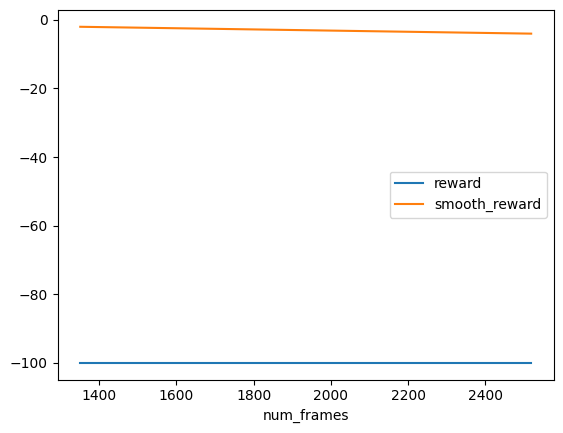

In [ ]:
args = Config()
args.use_critic=True
args.lr = 1e-5
args.max_episodes = 2
# args.use_discounted_reward=True

# df, acmodel = run_experiment(args, update_parameters_reinforce)
df, acmodel = run_experiment(args, UAASParameterUpdate(0.05, 0.1))
df.plot(x='num_frames', y=['reward', 'smooth_reward'])

########## set up env
env = gym.make('Boxing-v4', render_mode="rgb_array")

video_folder = Path.cwd().absolute().joinpath('data').as_posix()
video_folder += '/'

env = gym.wrappers.RecordVideo(env, video_folder, name_prefix="test-video", episode_trigger=lambda x: x % 2 == 0)
obs, _ = env.reset()
env.start_video_recorder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
###########

for _ in range(1000):
    preprocessed_obs = preprocess_obss(obs, device=device)

    with torch.no_grad():
        dist, value = acmodel(preprocessed_obs)
    action_probs = torch.softmax(dist.logits, dim=-1)
    action = torch.argmax(action_probs)

    action = env.action_space.sample()  # agent policy that uses the observation and info
    obs, reward, done, _, _ = env.step(action)
    # env.render()

    if terminated or truncated:
        obs, info = env.reset()
##########
env.close_video_recorder()

# Close the environment
env.close()

print(video_folder)
play_video(video_folder, "test-video-episode-0.mp4")


## Run REINFORCE with baseline

If you did everything right, you should be able to run the below cell to run the vanilla policy gradients implementation with baseline.  This should be somewhat more stable than without the baseline, and likely converge faster.


 23%|██▎       | 466/2000 [04:00<13:12,  1.94it/s]

Solved!


<Axes: xlabel='num_frames'>

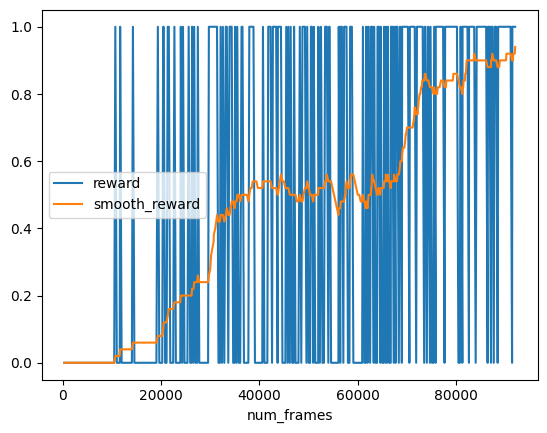

In [ ]:
args = Config(use_critic=True)
df_baseline = run_experiment(args, update_parameters_with_baseline)

df_baseline.plot(x='num_frames', y=['reward', 'smooth_reward'])

In [ ]:
# print(acmodel)
env = gym.make('Boxing-v4', render_mode="rgb_array")

env = gym.wrappers.RecordVideo(env, video_folder, name_prefix="test-video", episode_trigger=lambda x: x % 2 == 0)
obs, _ = env.reset()
env.start_video_recorder()

for _ in range(1000):
    preprocessed_obs = preprocess_obss(obs, device=device)
    with torch.no_grad():
        dist, value = acmodel(preprocessed_obs)
    action_probs = torch.softmax(dist.logits, dim=-1)
    action = torch.argmax(action_probs)

    obs, reward, done, _, _ = env.step(action)
    # env.render()

    if terminated or truncated:
        obs, info = env.reset()
##########
env.close_video_recorder()

# Close the environment
env.close()

print(video_folder)
play_video(video_folder, "test-video-episode-0.mp4")

Moviepy - Building video /content/data/test-video-episode-0.mp4.
Moviepy - Writing video /content/data/test-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/data/test-video-episode-0.mp4


Moviepy - Building video /content/data/test-video-episode-0.mp4.
Moviepy - Writing video /content/data/test-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/data/test-video-episode-0.mp4
/content/data/


FileNotFoundError: [Errno 2] No such file or directory: 'comp.mp4'

# Reinforce with GAE

The advantage we computed above seemed to work, and hopefully improved our results! Fortunately, we can do even better. The paper Generalized Advantage Estimation describes a nifty method for building a strong advantage estimate (see formula 16 in the paper) that empirically outperforms a naive subtraction (and includes reward shaping). Implemented the GAE function we left blank from earlier.

 28%|██▊       | 563/2000 [04:31<11:32,  2.08it/s]

Solved!


<Axes: xlabel='num_frames'>

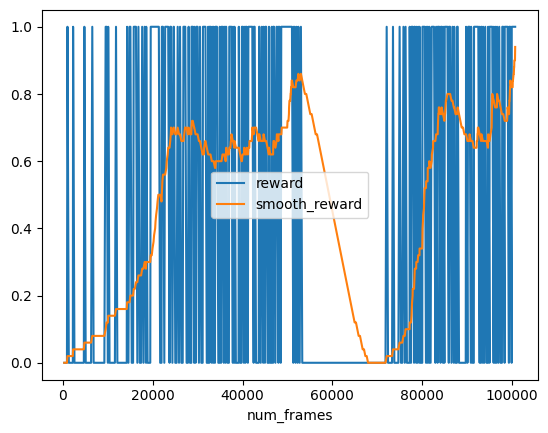

In [ ]:
args = Config(use_critic=True, use_gae=True)
df_gae = run_experiment(args, update_parameters_with_baseline)

df_gae.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Fancy Plots
If you've gotten to this point, congrats: you've succesfully implemented REINFORCE, VPG, and GAE!

**(10 pts)** Now let's visualize every result in one plot.

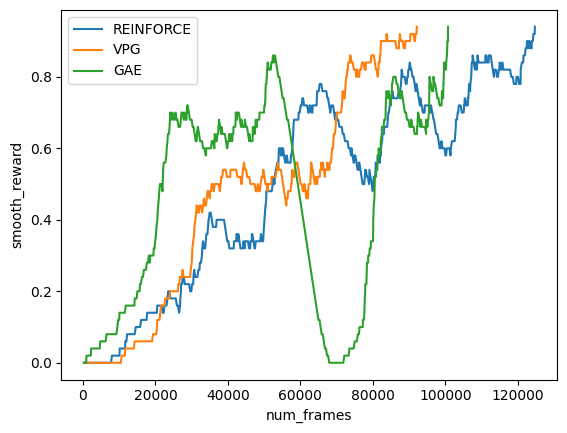

In [ ]:
# TODO Visualize all results into one plot.

# plot(df['num_frames'], df['smooth_reward'])

ax = None
for t, name in ((df, 'REINFORCE'), (df_baseline, 'VPG'), (df_gae, 'GAE')):
  t = t.rename(columns={'smooth_reward': name})
  ax = t.plot(ax=ax, x='num_frames', y=name, ylabel='smooth_reward')